<a href="https://colab.research.google.com/github/pdelfidali/SNDL/blob/main/MNIST_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# load dependencies
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset
from torchvision import models, datasets, transforms
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [10]:
# load data
mnist_train = datasets.MNIST(root='data', train = True, download = True, transform = transforms.ToTensor())
mnist_test = datasets.MNIST(root='data', train = False, download = True, transform = transforms.ToTensor())

In [13]:
train_indices, val_indices, _, _ = train_test_split(
    range(len(mnist_train)),
    mnist_train.targets,
    stratify=mnist_train.targets,
    test_size=0.1,
)

# generate subset based on indices
train_split = Subset(mnist_train, train_indices)
val_split = Subset(mnist_train, val_indices)

train_set = DataLoader(train_split, batch_size=32, shuffle=True)
val_set = DataLoader(val_split, batch_size=32, shuffle=True)

60000
10000
torch.Size([1, 28, 28])


<function matplotlib.pyplot.show(close=None, block=None)>

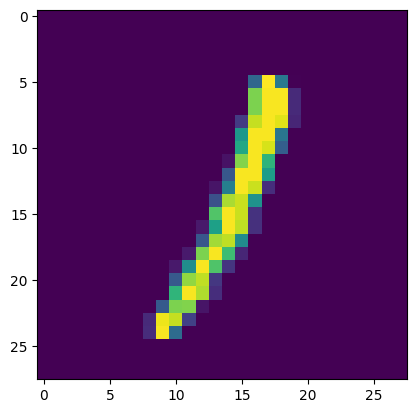

In [14]:
print(len(mnist_train))
print(len(mnist_test))
img, label = mnist_train[99]
print(img.shape)

label
plt.imshow(img.permute(1, 2, 0))
plt.show

In [15]:
class ImageClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(1, 32, (3,3)),
        nn.ReLU(),
        nn.Conv2d(32, 64, (3,3)),
        nn.ReLU(),
        nn.Conv2d(64, 64, (3,3)),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(64*(28-6)*(28-6),10),
        nn.Softmax()
    )

  def forward(self, x):
    return self.model(x)

In [16]:
# create an instiance of your image classifier, loss, and optimizer
clf = ImageClassifier().to('cuda')
opt = Adam(clf.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# training
if __name__ == '__main__':
  for epoch in range(10):
    for batch in train_set:
      x, y = batch
      x, y = x.to('cuda'), y.to('cuda')
      ypred = clf(x)
      loss = loss_fn(ypred, y)

      # apply backprop
      opt.zero_grad()
      loss.backward()
      opt.step()
    with torch.no_grad():
      for imgs, labels in val_set:
          imgs, labels = imgs.to('cuda'), labels.to('cuda')
          outputs = clf(imgs)
          val_loss = loss_fn(outputs, labels)

    print(f'Epoch:{epoch} loss: {loss.item()} val_loss: {val_loss}, loss-val_loss: {loss - val_loss}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch:0 loss: 1.4611719846725464 val_loss: 1.4611505270004272, loss-val_loss: 2.1457672119140625e-05
Epoch:1 loss: 1.5236505270004272 val_loss: 1.5236504077911377, loss-val_loss: 1.1920928955078125e-07
Epoch:2 loss: 1.5236504077911377 val_loss: 1.4611505270004272, loss-val_loss: 0.06249988079071045
Epoch:3 loss: 1.5861504077911377 val_loss: 1.4611505270004272, loss-val_loss: 0.12499988079071045
Epoch:4 loss: 1.4611505270004272 val_loss: 1.5236504077911377, loss-val_loss: -0.06249988079071045
Epoch:5 loss: 1.4611505270004272 val_loss: 1.5861504077911377, loss-val_loss: -0.12499988079071045
Epoch:6 loss: 1.4611505270004272 val_loss: 1.6486504077911377, loss-val_loss: -0.18749988079071045
Epoch:7 loss: 1.4611505270004272 val_loss: 1.5236505270004272, loss-val_loss: -0.0625


60000
Label:  7
Prediction:  tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Prediction:  tensor(7, device='cuda:0')


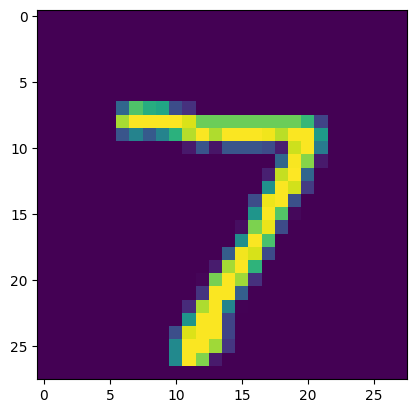

In [19]:
# test our clf
print(len(mnist_train))
len(dataset)  # 32 * 1875 = 60000

img, label = mnist_test[0]
print('Label: ', label)
plt.imshow(img.permute(1, 2, 0))
plt.show

# transform the image into the right shape
img = img.unsqueeze(0).to('cuda')
print('Prediction: ', clf(img))
print('Prediction: ', torch.argmax(clf(img)))


Accuracy: 96.46%


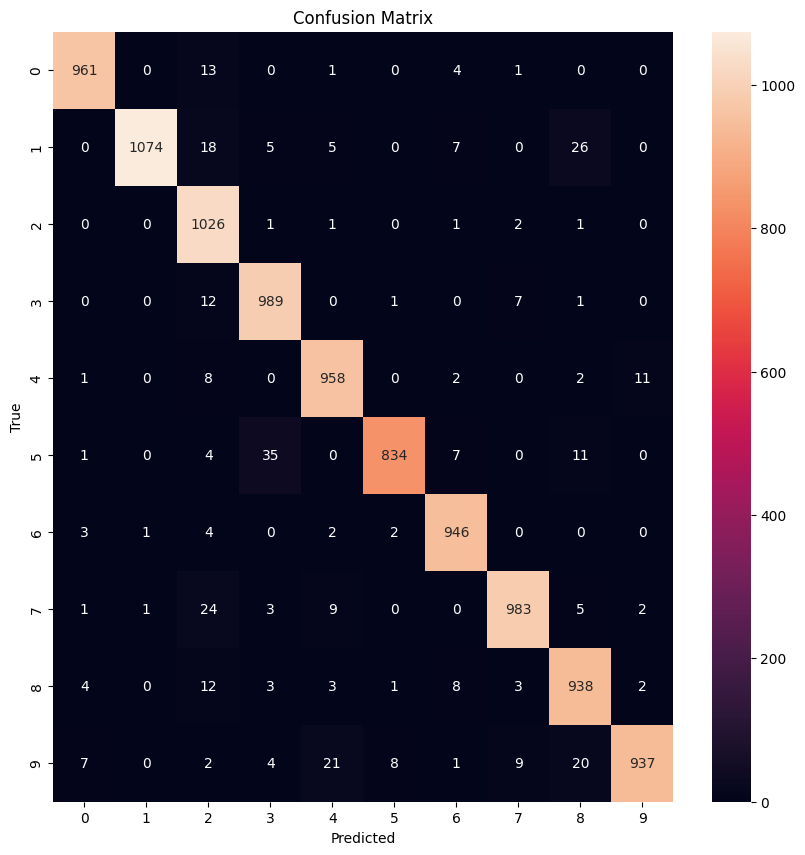

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
from torch.utils.data import DataLoader

test_set = DataLoader(mnist_test, batch_size = 32, shuffle = False)

correct = 0
total = 0
all_predicted = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_set:
        imgs, labels = imgs.to('cuda'), labels.to('cuda')
        outputs = clf(imgs)
        predicted = torch.argmax(outputs, dim = 1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy: {correct / total * 100:.2f}%")

cm = confusion_matrix(all_labels, all_predicted)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
